# Marvel Cinematic Universe (MCU) - Wikidata SPARQL Project
This project uses SPARQL to query [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) and viisualizes the actors/actresses and directors that appear most commonly in [MCU](https://www.wikidata.org/wiki/Q642878) movies.

### Import modules

In [1]:
import requests

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

URL = 'https://query.wikidata.org/sparql'

## Query for directors
We first use SPARQL to query MCU movies, directors, and publish date. The results are then sorted by publish date.

Define constants from Wikidata for SPARQL

In [2]:
mcu = 'Q642878'

fictions = 'P1445'
instance_of = 'P31'

film = 'Q11424'

pub_date = 'P577'
title = 'P1476'
language = 'P364'
en = 'Q1860'

ratings = 'P444'
imdb = 'P345'

director = 'P57'
first_name = 'P735'
last_name = 'P734'

### Query

In [3]:
query = f"""
SELECT DISTINCT
  ?name
  (MIN(?date) AS ?earliest_date) # for each movie, define its publish date as the earliest publish date
  ?director_name
  ?imdb_obj
WHERE {{
  wd:{mcu} wdt:{fictions} ?movie .
  ?movie wdt:{instance_of} wd:{film} .
  ?movie rdfs:label ?name . FILTER(LANG(?name) = "en") .
  ?movie wdt:{pub_date} ?date . FILTER(YEAR(?date) < 2025) . # published before 2025
  ?movie wdt:{director} ?director_obj . ?director_obj rdfs:label ?director_name . FILTER(LANG(?director_name) = "en") .
  ?movie wdt:{imdb} ?imdb_obj .
}}
GROUP BY
  ?name
  ?director_name
  ?imdb_obj
ORDER BY
  ?earliest_date
"""


In [4]:
r = requests.get(URL, params = {'format': 'json', 'query': query})
data = r.json()
data['results']['bindings'][:3]

[{'name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Iron Man'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2008-05-02T00:00:00Z'},
  'director_name': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Jon Favreau'},
  'imdb_obj': {'type': 'literal', 'value': 'tt0371746'}},
 {'name': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'The Incredible Hulk'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2008-06-13T00:00:00Z'},
  'director_name': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Louis Leterrier'},
  'imdb_obj': {'type': 'literal', 'value': 'tt0800080'}},
 {'name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Iron Man 2'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2010-05-07T00:00:00Z'},
  'director_name': {'xml:lang': 'en',
   'type': 'literal',
   'val

In [5]:
def get_values(data):
    return list(map(lambda x: {p: x[p]["value"] for p in x}, data['results']['bindings']))

get_values(data)[:3]

[{'name': 'Iron Man',
  'earliest_date': '2008-05-02T00:00:00Z',
  'director_name': 'Jon Favreau',
  'imdb_obj': 'tt0371746'},
 {'name': 'The Incredible Hulk',
  'earliest_date': '2008-06-13T00:00:00Z',
  'director_name': 'Louis Leterrier',
  'imdb_obj': 'tt0800080'},
 {'name': 'Iron Man 2',
  'earliest_date': '2010-05-07T00:00:00Z',
  'director_name': 'Jon Favreau',
  'imdb_obj': 'tt1228705'}]

In [6]:
mcu_movies = pd.DataFrame(get_values(data))
mcu_movies.head(10)

,name,earliest_date,director_name,imdb_obj
0,Iron Man,2008-05-02T00:00:00Z,Jon Favreau,tt0371746
1,The Incredible Hulk,2008-06-13T00:00:00Z,Louis Leterrier,tt0800080
2,Iron Man 2,2010-05-07T00:00:00Z,Jon Favreau,tt1228705
3,Thor,2011-04-27T00:00:00Z,Kenneth Branagh,tt0800369
4,Captain America: The First Avenger,2011-07-22T00:00:00Z,Joe Johnston,tt0458339
5,The Avengers,2012-04-25T00:00:00Z,Joss Whedon,tt0848228
6,Iron Man 3,2013-04-24T00:00:00Z,Shane Black,tt1300854
7,Thor: The Dark World,2013-10-31T00:00:00Z,Alan Taylor,tt1981115
8,Captain America: The Winter Soldier,2014-03-26T00:00:00Z,Anthony Russo,tt1843866
9,Captain America: The Winter Soldier,2014-03-26T00:00:00Z,Joe Russo,tt1843866


In [7]:
mcu_directors = mcu_movies.groupby('director_name').size().sort_values(ascending=False)
mcu_directors.head(10)

director_name
Joe Russo        4
Anthony Russo    4
James Gunn       4
Peyton Reed      3
Jon Watts        3
Joss Whedon      2
Ryan Coogler     2
Jon Favreau      2
Taika Waititi    2
Joe Johnston     1
dtype: int64

In [8]:
def plot_stats(df, title='', xlabel='', ylabel='Count', limit=10, xrot=45, int_y=True):
    import matplotlib.ticker as ticker
    
    df.head(limit).plot(kind='bar', figsize=(10, 5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.xticks(rotation=xrot, ha='right')
    if int_y:
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.show()

### Visualization
Plot top ten directors that directed most MCU movies.

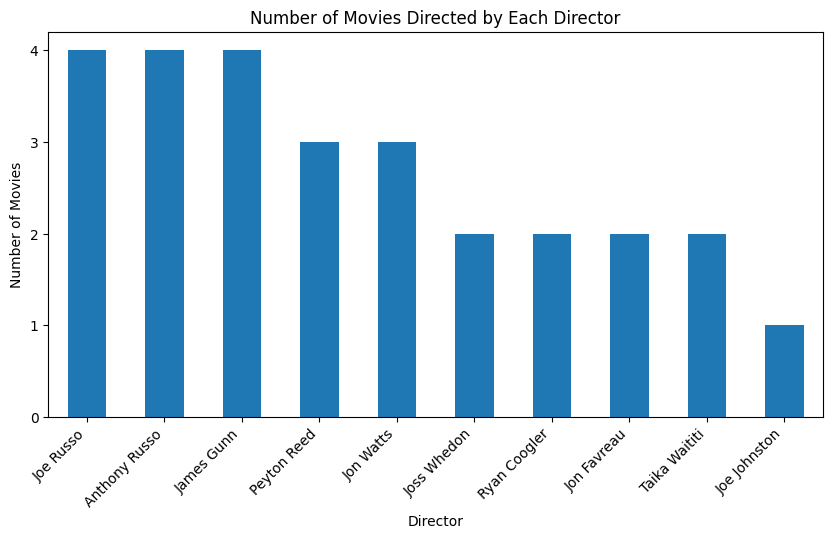

In [9]:
# visualize how many movies each director has made
plot_stats(
    mcu_directors,
    title='Number of Movies Directed by Each Director',
    xlabel='Director',
    ylabel='Number of Movies',
)

## Query for actors
This SPARQL query fetches all actors that have participated in MCU movies.

In [10]:
actors = 'P161'
character_name = 'P4633'

### Query

In [11]:
query_actors = f"""
SELECT DISTINCT
  ?name
  (MIN(?date) AS ?earliest_date) # for each movie, define its publish date as the earliest publish date
  ?actor_name
  ?character_name
WHERE {{
  wd:{mcu} wdt:{fictions} ?movie .
  ?movie wdt:{instance_of} wd:{film} .
  ?movie rdfs:label ?name . FILTER(LANG(?name) = "en") .
  ?movie wdt:{pub_date} ?date . FILTER(YEAR(?date) < 2025) . # published before 2025
  ?movie p:{actors} ?actor_state .
    ?actor_state ps:{actors} ?actor . ?actor rdfs:label ?actor_name . FILTER(LANG(?actor_name) = "en") .
    ?actor_state pq:{character_name} ?character_name .
}}
GROUP BY
  ?name
  ?actor_name
  ?character_name
ORDER BY
?earliest_date
"""

In [12]:
r = requests.get(URL, params = {'format': 'json', 'query': query_actors})
data_actors = r.json()
data_actors['results']['bindings'][:3]

[{'name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Iron Man'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2008-05-02T00:00:00Z'},
  'actor_name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Stan Lee'},
  'character_name': {'type': 'literal', 'value': 'Himself'}},
 {'name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Iron Man'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2008-05-02T00:00:00Z'},
  'actor_name': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Gwyneth Paltrow'},
  'character_name': {'type': 'literal', 'value': 'Pepper Potts'}},
 {'name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Iron Man'},
  'earliest_date': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '2008-05-02T00:00:00Z'},
  'actor_name': {'xml:lang': 'en', 'type': 'literal', 'value': 'Jon Favreau'},
  'charac

In [13]:
mcu_actors = pd.DataFrame(get_values(data_actors))
mcu_actors.head()

,name,earliest_date,actor_name,character_name
0,Iron Man,2008-05-02T00:00:00Z,Stan Lee,Himself
1,Iron Man,2008-05-02T00:00:00Z,Gwyneth Paltrow,Pepper Potts
2,Iron Man,2008-05-02T00:00:00Z,Jon Favreau,Hogan
3,Iron Man,2008-05-02T00:00:00Z,Robert Downey Jr.,Tony Stark
4,Iron Man,2008-05-02T00:00:00Z,Meera Simhan,Reporters


In [14]:
mcu_actors_stats = mcu_actors.groupby('actor_name').size().sort_values(ascending=False)
mcu_actors_stats.head(10)

actor_name
Stan Lee              20
Chris Evans           10
Robert Downey Jr.      9
Scarlett Johansson     8
Samuel L. Jackson      8
Don Cheadle            8
Chris Hemsworth        8
Gwyneth Paltrow        7
Brian Schaeffer        6
Tom Hiddleston         6
dtype: int64

In [15]:
mcu_actors_stats["Benedict Cumberbatch"]

4

### Visualization

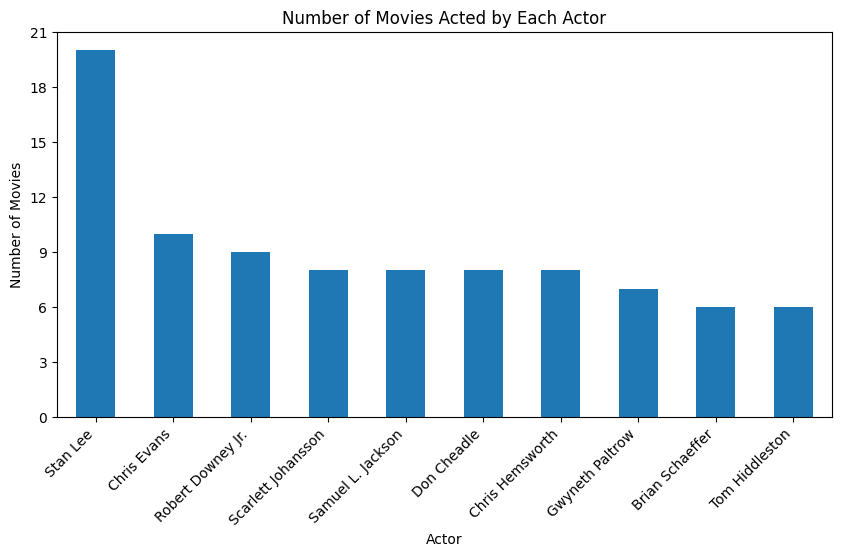

In [16]:
plot_stats(
    mcu_actors_stats,
    title='Number of Movies Acted by Each Actor',
    xlabel='Actor',
    ylabel='Number of Movies'
)

In [17]:
topten_mcu_actors = mcu_actors_stats.head(10).index
list(topten_mcu_actors)

['Stan Lee',
 'Chris Evans',
 'Robert Downey Jr.',
 'Scarlett Johansson',
 'Samuel L. Jackson',
 'Don Cheadle',
 'Chris Hemsworth',
 'Gwyneth Paltrow',
 'Brian Schaeffer',
 'Tom Hiddleston']

In [18]:
mcu_movies_10actors = mcu_actors[mcu_actors["actor_name"].isin(topten_mcu_actors)].sort_values("earliest_date")[["name", "actor_name"]]
#.sort_values("actor_name", key=lambda x: x.map(topten_mcu_actors.tolist().index))
mcu_movies_10actors.head(5)

,name,actor_name
0,Iron Man,Stan Lee
1,Iron Man,Gwyneth Paltrow
3,Iron Man,Robert Downey Jr.
128,Iron Man 2,Gwyneth Paltrow
129,Iron Man 2,Scarlett Johansson


In [19]:
# get movies and actors as edges
edges = mcu_movies_10actors.values
edges[:5]

array([['Iron Man', 'Stan Lee'],
       ['Iron Man', 'Gwyneth Paltrow'],
       ['Iron Man', 'Robert Downey Jr.'],
       ['Iron Man 2', 'Gwyneth Paltrow'],
       ['Iron Man 2', 'Scarlett Johansson']], dtype=object)

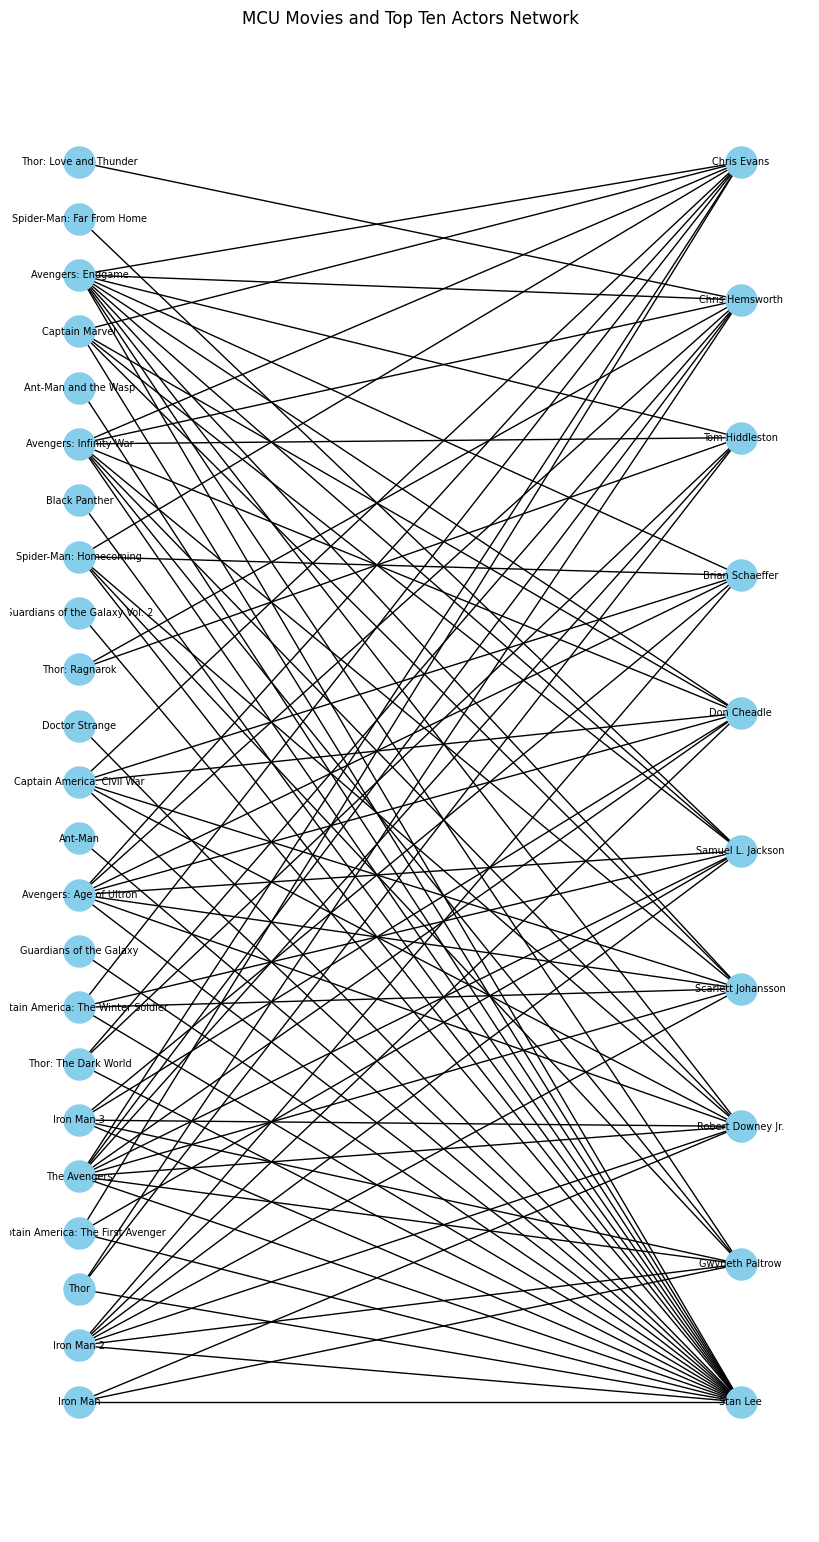

In [20]:
import networkx as nx
# create a graph from the edges
G = nx.from_edgelist(edges)

# plot the graph
plt.figure(figsize=(8, 15))
pos = nx.bipartite_layout(G, mcu_movies_10actors["name"].unique())
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=7)
plt.title('MCU Movies and Top Ten Actors Network')
plt.show()